In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import neo #Electrophys Tool
import pandas as pd
import scipy as scp
from IPython.display import HTML  # to format HINT buttons
import time

#Widget Things
import ipywidgets as wid
from IPython.display import display

In [2]:
%%html
<style>
  details summary {
    background-color: #ADD8E6;
    color: white;
    padding: 10px;
    border-radius: 5px;
    cursor: pointer;
    width: 155px;
  }
</style>

## Widget Learning

### Practice

In [10]:
# Get a list of widgets
# Useful site: https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916
print(dir(wid))

['Accordion', 'AppLayout', 'Audio', 'BoundedFloatText', 'BoundedIntText', 'Box', 'Button', 'ButtonStyle', 'CallbackDispatcher', 'Checkbox', 'Color', 'ColorPicker', 'ColorsInput', 'Combobox', 'Controller', 'CoreWidget', 'DOMWidget', 'DatePicker', 'Datetime', 'DatetimePicker', 'Dropdown', 'FileUpload', 'FloatLogSlider', 'FloatProgress', 'FloatRangeSlider', 'FloatSlider', 'FloatText', 'FloatsInput', 'GridBox', 'GridspecLayout', 'HBox', 'HTML', 'HTMLMath', 'Image', 'IntProgress', 'IntRangeSlider', 'IntSlider', 'IntText', 'IntsInput', 'Label', 'Layout', 'NaiveDatetimePicker', 'NumberFormat', 'Output', 'Password', 'Play', 'RadioButtons', 'Select', 'SelectMultiple', 'SelectionRangeSlider', 'SelectionSlider', 'SliderStyle', 'Stack', 'Style', 'Tab', 'TagsInput', 'Text', 'Textarea', 'TimePicker', 'ToggleButton', 'ToggleButtons', 'ToggleButtonsStyle', 'TwoByTwoLayout', 'TypedTuple', 'VBox', 'Valid', 'ValueWidget', 'Video', 'Widget', '__builtins__', '__cached__', '__doc__', '__file__', '__jupyter_

In [11]:
#Make a slider
frog = wid.IntSlider(
    min=0,
    max=10,
    step=1,
    description='# of Days:',
    value=3
)


In [12]:
# Make a button
btn = wid.Button(description='Medium')
display(btn,output)
def btn_eventhandler(obj):
    with output:
        print('Hello from the {} button!'.format(obj.description))
btn.on_click(btn_eventhandler)

#Try 2
button = wid.Button(description="Click Me!")
output = wid.Output()

display(button, output)

def on_button_clicked(arb):
    with output:
        print("Button clicke{}d.".format(arb.description))

button.on_click(on_button_clicked)

NameError: name 'output' is not defined

In [ ]:
text = wid.IntText()
display(frog, text)
wid.jslink((frog, 'value'), (text, 'value'))

In [ ]:
dropdown_year = wid.Dropdown(name = 'Days',options = np.array([1,2,3,4,5,6,7]))

new_output = wid.Output()

def dropdown_year_eventhandler(change):
    new_output.clear_output()
    if (change.new == 7):
        with new_output:
            print('Frog')
    else:
        with new_output:
            print('Cats!')

dropdown_year.observe(dropdown_year_eventhandler, names='value')

display(dropdown_year)

In [ ]:
display(new_output)

### Application: Folder Review

In [ ]:
# Folder access
uploader = wid.Text(description = 'Name Folder',disabled = 0, placeholder = 'Ex: CBSC')
display(uploader)

uploader.continuous_update = 0
uploader_output = wid.Output()

def Whats_In_Folder(obs):
    uploader_output.clear_output()
    if os.path.exists(uploader.value):
        with uploader_output:
            files = os.listdir(uploader.value)
            for file in files:
                if file.find('.')!=0: #Avoid hidden files
                    print(file)
    else:
        with uploader_output:
            print("This folder name doesn't exist in the path :( ")

uploader.observe(Whats_In_Folder,names = 'value')


In [ ]:
display(uploader_output)

## Important Functions

In [3]:
#THE BEST one as of 21 Jan
# Description: plexon_import takes a single file and provides the left, right, and piezo data,
# as well as the familiar and novel event times

def plexon_import(filepath):

    reader = neo.PlexonIO(filepath)
    blks = reader.read()
    seg = blks[0].segments[0]
    seg.data_children
    
    #Get analog signal
    sig = seg.analogsignals[0]
    
    #Each sig index is one millisecond, but need to sort out the multiple channel issue
    sigLH = sig[:,0] #Left Hemisphere
    sigRH = sig[:,1] #Right Hemisphere
    sigPz = sig[:,2] #Piezo Data
    
    #Extract data and time series to use
    datLH = sigLH.data
    datRH = sigRH.data
    datPz = sigPz.data
    
    #Reshape data so it's just a 1-D array so it can plot
    shape = datLH.shape[0] #shape shouldn't change
    datLH = np.reshape(datLH,(shape)) 
    datRH = np.reshape(datRH,(shape)) 
    datPz = np.reshape(datPz,(shape)) 
    
    #Smooth
    Notcha,Notchb = scp.signal.iirnotch(60,100,fs=1000)
    datLH = scp.signal.filtfilt(Notcha,Notchb,datLH)
    datRH = scp.signal.filtfilt(Notcha,Notchb,datRH)
    datPz = scp.signal.filtfilt(Notcha,Notchb,datPz)
    
    #Event_times stores the time each strobe event occured
    #Event_labels stores the label (1,2 is familiar, 0 is grey screen, 3,4 is phase shifted)
    event_times = [e.times for e in seg.events]
    event_labels = [e.labels for e in seg.events]

    #Normalize the data to a baseline based on the mean
    base_end = int(min(event_times[3])*1000) #Convert to a millisecond unit of time
    base_start = 0 
    datLH = datLH - np.mean(datLH[base_start:base_end])
    datRH = datRH - np.mean(datRH[base_start:base_end])
    
    #Figure out which strobe event is happening
    event_familiar = []
    event_novel = []
    event_gray = []
    for event in range(0,len(event_labels[3]),1):
        if event_labels[3][event] in ['1','2']: 
            event_familiar.append(event_times[3][event])
        elif event_labels[3][event] in ['3','4']: 
            event_novel.append(event_times[3][event])
        else:
            event_gray.append(event_times[3][event])
    
    return datLH,datRH,datPz,event_familiar,event_novel

In [4]:
#Strobe_Split_Single breaks each event into blocks of 500, as each phase is 500 milliseconds
def Strobe_Split_Single(DataIn,Events):
    
    #Create the strobe sample blank arrays as real arrays
    Strobe_Split = np.zeros((1001,500)) #Figure out how to replace 999 with len(Events)
    
    #For each strobe event, pick the 500 samples at that time point
    i = 0
    for j in Events:
        Strobe_Split[i,:] = DataIn[int(j*1000)-100:int(j*1000)+400]
        i+=1
   
    return Strobe_Split

#Higher level above strobe split single, allows splitting a full data block based on given days
def Strobe_Split(DataIn,Events,Start_Day,End_Day):
    #Create the strobe sample blank arrays as real arrays
    Output = []
    for day in range(Start_Day-1,End_Day,1):
        
        #Look over all mice for a given day
        Mice = []
        for mouse in range(0,len(DataIn[day]),1):

            #Put the strobes events into one line for each mouse
            Strobe = Strobe_Split_Single(DataIn[day][mouse],Events[day][mouse])
            
            Mice.append(Strobe)
            
        Output.append(Mice)
   
    return Output
    
#Strobe_Long Takes the raw data, and provides only the blocks of time where the events occurred
def Strobe_Long(DataIn,Events,Start_Day,End_Day):
    
    #Create the strobe sample blank arrays as real arrays
    Output = []
    for day in range(Start_Day-1,End_Day,1):
        
        #Look over all mice for a given day
        Long_Mice = []
        for mouse in range(0,len(DataIn[day]),1):

            #Put the strobes events into one line for each mouse
            Strobe_Long = np.zeros((len(Events[day][mouse])*500))
            i = 0
            for j in Events[day][mouse]:
                Strobe_Long[i:i+500] = DataIn[day][mouse][int(j*1000)-100:int(j*1000)+400]
                i+=500
            Long_Mice.append(Strobe_Long)
        Output.append(Long_Mice)
   
    return Output

#Strobe_Longest converts the raw data into the strobed events including gray time
def Strobe_Longest(DataIn,Events,Start_Day,End_Day):
    
    #Create the strobe sample blank arrays as real arrays
    Output = []
    for day in range(Start_Day-1,End_Day,1):
        
        #Look over all mice for a given day
        Long_Mice = []
        for mouse in range(0,len(DataIn[day]),1):

            #Put the strobes events into one line for each mouse
            Strobe_Long = np.zeros((len(Events[day][mouse])*500))
            Strobe_Start = Events[day][mouse][0]
            Strobe_End = Events[day][mouse][-1]
            
            Strobe_Long = DataIn[day][mouse][int(Strobe_Start*1000)-100:int(Strobe_Start*1000) + 624430]
            Long_Mice.append(Strobe_Long)
        Output.append(Long_Mice)
   
    return Output

## Gathering Data

### Creating Arrays with Novel and Familiar Split

In [19]:
#ARRAY STYLE Look through each day, storing it as datLH[Day #][Mouse #][Data] to allow comparing days and mice

start_time = time.time()

os.listdir("Mice Groups/CBSC")
start_day = 1
end_day = 2

datLH = [] #np.zeros((end_day-start_day+1, 35, 1000, 500))
datRH = [] #np.copy(datLH_Arr)
datPz = [] #np.copy(datLH_Arr)
Event_Fam = []
Event_Nov = []

for i in range(start_day,end_day+1,1):
    files = os.listdir("Mice Groups/CBSC/day " + str(i) + "/")
    datLH_mice = [] #np.zeros((end_day-start_day+1, 35, 1000, 500))
    datRH_mice = [] #np.copy(datLH_Arr)
    datPz_mice = [] #np.copy(datLH_Arr)
    Event_Fam_mice = []
    Event_Nov_mice = []
    #Creates three files, one for each reading type, split for each file (mouse)
    for file in files:
        fname = "Mice Groups/CBSC/day " + str(i) + "/" + file #Concatenate directory with file path to be able to run the function over all days
        if os.path.splitext(fname)[1] == '.plx':
            LH_single,RH_single,Pz_single,Event_Fam_single,Event_Nov_single = plexon_import(fname)
            datLH_mice.append(LH_single),datRH_mice.append(RH_single),datPz_mice.append(Pz_single),Event_Fam_mice.append(Event_Fam_single),Event_Nov_mice.append(Event_Nov_single)
    datLH.append(datLH_mice),datRH.append(datRH_mice),datPz.append(datPz_mice),Event_Fam.append(Event_Fam_mice),Event_Nov.append(Event_Nov_mice)

print("--- %s seconds ---" % (time.time() - start_time)) #Just to see how long it takes

Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 757680.72it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 361.54it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 192367.75it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 906876.54it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 358.07it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 111159.97it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 935780.97it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 352.95it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 91500.20it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 947100.90it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4

--- 60.92911100387573 seconds ---


In [5]:
#ARRAY STYLE Look through each day, storing it as datLH[Day #][Mouse #][Data] to allow comparing days and mice

start_time = time.time()

os.listdir("Mice Groups/16p Micro-deletion mice")
start_day = 1
end_day = 2

datLH = [] #np.zeros((end_day-start_day+1, 35, 1000, 500))
datRH = [] #np.copy(datLH_Arr)
datPz = [] #np.copy(datLH_Arr)
Event_Fam = []
Event_Nov = []


files = os.listdir("Mice Groups/16p Micro-deletion mice/16p hab 1")
datLH_mice = [] #np.zeros((end_day-start_day+1, 35, 1000, 500))
datRH_mice = [] #np.copy(datLH_Arr)
datPz_mice = [] #np.copy(datLH_Arr)
Event_Fam_mice = []
Event_Nov_mice = []
#Creates three files, one for each reading type, split for each file (mouse)
for file in files:
    fname = "Mice Groups/16p Micro-deletion mice/16p hab 1" + "/" + file #Concatenate directory with file path to be able to run the function over all days
    if os.path.splitext(fname)[1] == '.plx':
        LH_single,RH_single,Pz_single,Event_Fam_single,Event_Nov_single = plexon_import(fname)
        datLH_mice.append(LH_single),datRH_mice.append(RH_single),datPz_mice.append(Pz_single),Event_Fam_mice.append(Event_Fam_single),Event_Nov_mice.append(Event_Nov_single)
datLH.append(datLH_mice),datRH.append(datRH_mice),datPz.append(datPz_mice),Event_Fam.append(Event_Fam_mice),Event_Nov.append(Event_Nov_mice)

print("--- %s seconds ---" % (time.time() - start_time)) #Just to see how long it takes

Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 577103.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 175.76it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 124407.32it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 947100.90it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 160.29it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 154222.60it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 950935.32it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 176.72it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 122270.18it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 876421.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4

--- 12.86014199256897 seconds ---


### Creating An Array of DayMice, from Strobing Start to End
* Keeping here for now, but may be obsolete

In [36]:
#ARRAY STYLE Function to pull in the data for a given file
def plexon_array_long(filepath):
    
    reader = neo.PlexonIO(filepath)
    blks = reader.read()
    seg = blks[0].segments[0]
    seg.data_children

    #Get analog signal
    sig = seg.analogsignals[0]
    
    #Each sig index is one millisecond, but need to sort out the multiple channel issue
    sigLH = sig[:,0] #Left Hemisphere
    sigRH = sig[:,1] #Right Hemisphere
    sigPz = sig[:,2] #Piezo Data
    
    #Extract data and time series to use
    datLH = sigLH.data
    datRH = sigRH.data
    datPz = sigPz.data

    #Reshape data so it's just a 1-D array so it can plot
    shape = datLH.shape[0] #shape shouldn't change
    datLH = np.reshape(datLH,(shape)) 
    datRH = np.reshape(datRH,(shape)) 
    datPz = np.reshape(datPz,(shape)) 
    
    #Event_times stores the time each strobe event occured
    event_times = [e.times for e in seg.events]
    strobe_start = int(event_times[3][0]*1000)
    #Create the strobe sample blank arrays as real arrays
    strobe_split_LH = np.array(datLH[strobe_start-100:strobe_start+1236*500+100])
    strobe_split_RH = np.array(datRH[strobe_start-100:strobe_start+1236*500+100])
    strobe_split_Pz = np.array(datPz[strobe_start-100:strobe_start+1236*500+100])

    return strobe_split_LH,strobe_split_RH,strobe_split_Pz


In [37]:
#ARRAY STYLE Look through each day, storing it as datLH[Day #][Mouse #][Data] to have full strobe course

start_time = time.time()

os.listdir("CBSC")
days = 2
if days >= 7:
    days = 6

datLH_Long = np.zeros((days, 35,618200))
datRH_Long = np.copy(datLH_Long)
datPz_Long = np.copy(datLH_Long)

for i in range(1,days+1,1):
    files = os.listdir("CBSC/day " + str(i) + "/")

    #Creates three files, one for each reading type, split for each file (mouse)
    j = 0
    for file in files:
        fname = "CBSC/day " + str(i) + "/" + file #Concatenate directory with file path to be able to run the function over all days
        datLH_Long[i-1][j][:],datRH_Long[i-1][j][:],datPz_Long[i-1][j][:] = plexon_array_long(fname)
        j += 1

print(f'The shape of datLH_Days is: {datLH_Long.shape}')

print("--- %s seconds ---" % (time.time() - start_time)) #Just to see how long it takes

Finalizing data blocks for type 1: 100%|█████| 56/56 [00:00<00:00, 82097.53it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 229.08it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 17256.71it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 623026.59it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 228.98it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 79674.70it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 542450.40it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 242.65it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 141154.46it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 538717.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4

The shape of datLH_Days is: (2, 35, 618200)
--- 80.65075778961182 seconds ---


## Data Analysis

### Piezo Novel Stimulus Over Days

In [70]:
#Use Strobe_Longest to get the blocks of stimulus time for each mouse 
start = 1
end = 7
Pz_Longest = Strobe_Longest(datPz,Event_Fam,start,end)
len(Pz_Longest[0])

34

In [76]:
#Average for each day
Pz_Days = np.zeros([6,624530])
for i in range(0,6,1):
    Pz_Norm = np.zeros([len(Pz_Longest[i]),624530])
    for mouse in range(0,len(Pz_Longest[i]),1):
        Pz_Norm[mouse] = np.sqrt(Pz_Longest[i][mouse] ** 2)
    Pz_Days[i] = np.mean(Pz_Norm,axis = 0)


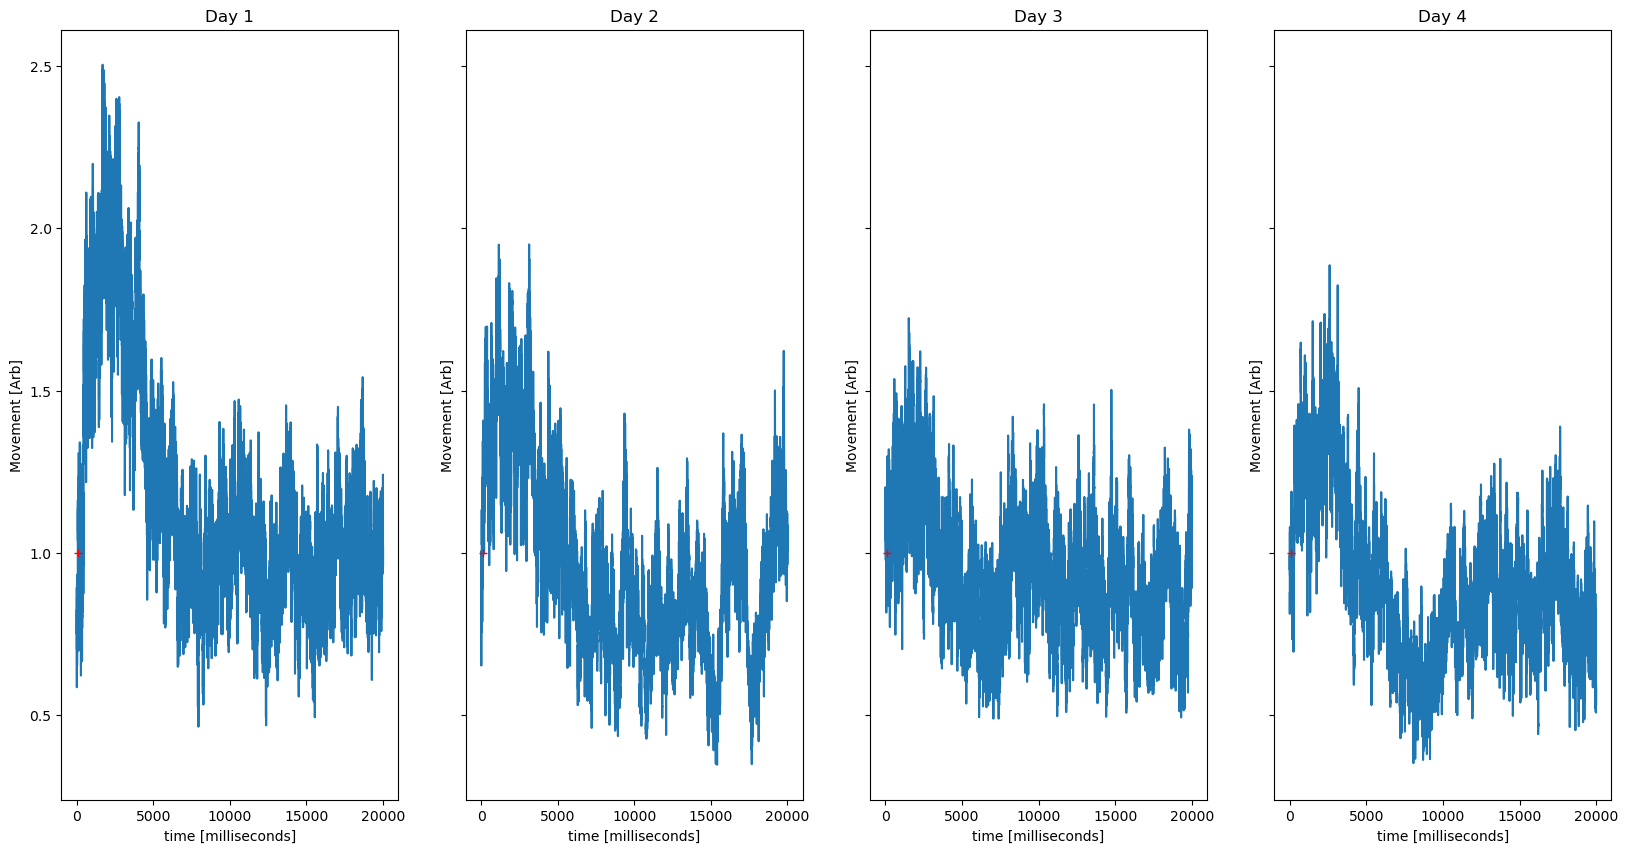

In [72]:
f, ax = plt.subplots(1,4, figsize=(20,10),sharey=True)

for i in range(0,4,1):

    ax = plt.subplot(1,4,i+1)
    plt.plot(Pz_Days[i][0:20000])
    #plt.plot(strobe_mean_LH_D4)
    #plt.legend(['Day 1','Day 4','Day 6'])
    #plt.plot(strobe_std_LH[0])
    plt.plot(100,1,'r+')
    plt.title(f"Day {i+1}")
    plt.xlabel('time [milliseconds]')
    plt.ylabel('Movement [Arb]')
    

### Piezo Data Novel Comparison

In [73]:
# Just Looking at last day, first novel stim
start = 7
end = 7
Pz_Long_Nov = Strobe_Longest(datPz,Event_Nov,start,end)
len(Pz_Long_Nov)

1

In [74]:
#Average for each day
Pz_Days_Nov = np.zeros([624530])
Pz_Norm = []
for mouse in range(0,len(Pz_Long_Nov[0]),1):
    Pz_Norm.append(np.sqrt(Pz_Long_Nov[0][mouse] ** 2)[:324530])
Pz_Nov = np.mean(Pz_Norm,axis=0)


Text(0, 0.5, 'Movement [Arb]')

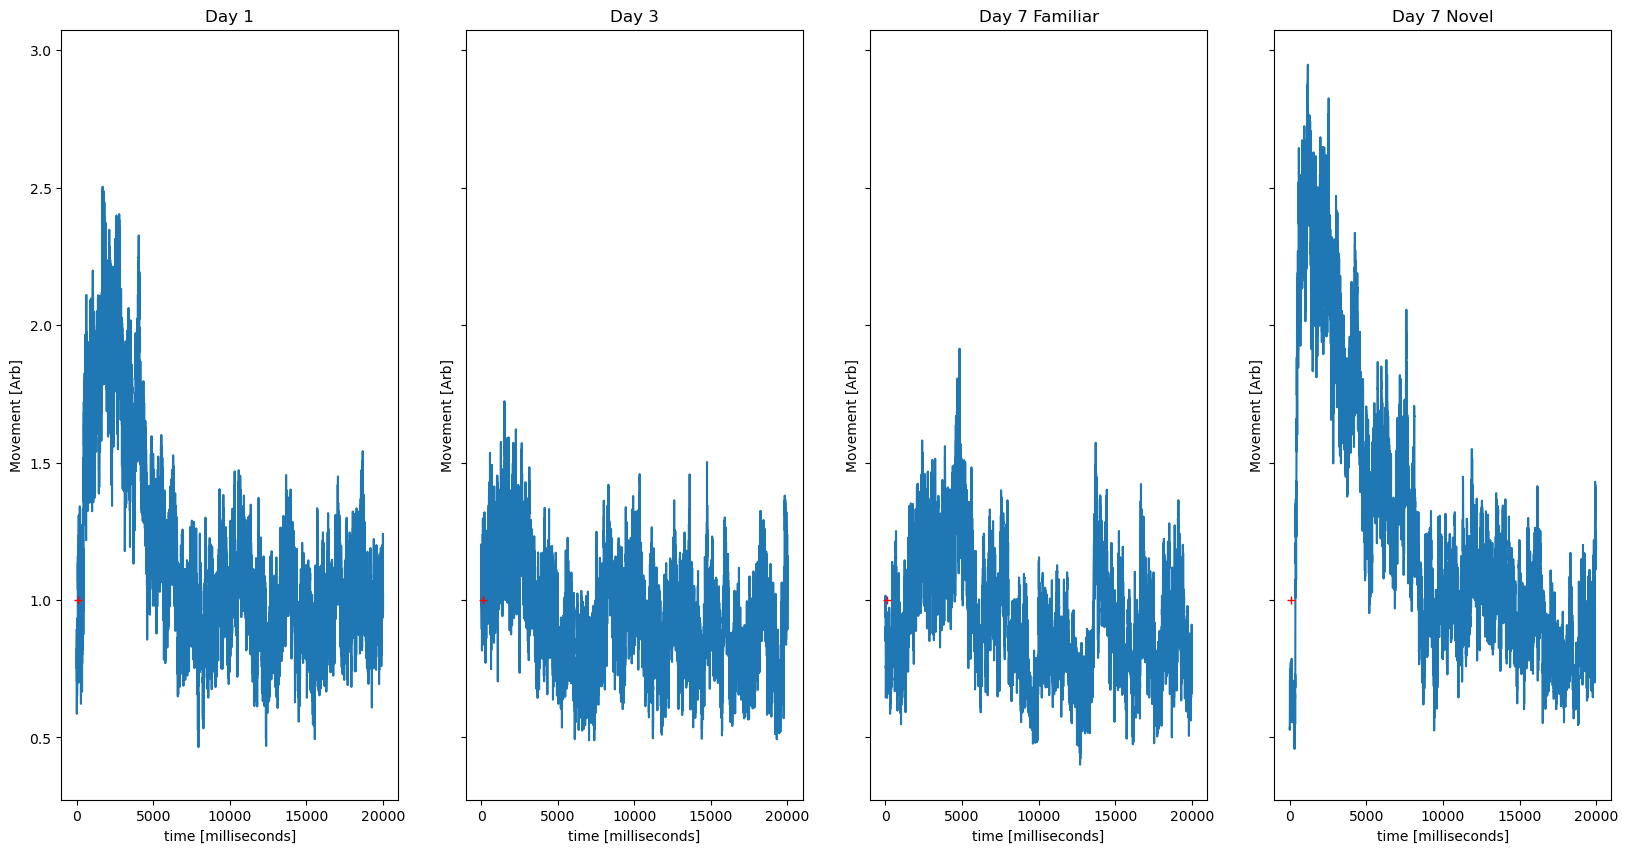

In [81]:
f, ax = plt.subplots(1,4, figsize=(20,10),sharey=True)

ax = plt.subplot(1,4,1)
plt.plot(Pz_Days[0][0:20000])
plt.plot(100,1,'r+')
plt.title("Day 1")
plt.xlabel('time [milliseconds]')
plt.ylabel('Movement [Arb]')

ax = plt.subplot(1,4,2)
plt.plot(Pz_Days[2][0:20000])
plt.plot(100,1,'r+')
plt.title("Day 3")
plt.xlabel('time [milliseconds]')
plt.ylabel('Movement [Arb]')

ax = plt.subplot(1,4,3)
plt.plot(Pz_Days[5][0:20000])
plt.plot(100,1,'r+')
plt.title("Day 7 Familiar")
plt.xlabel('time [milliseconds]')
plt.ylabel('Movement [Arb]')

ax = plt.subplot(1,4,4)
plt.plot(Pz_Nov[0:20000])
plt.plot(100,1,'r+')
plt.title("Day 7 Novel")
plt.xlabel('time [milliseconds]')
plt.ylabel('Movement [Arb]')

### Comparing Single Strobe Events over Days of WT

In [33]:
datLH_Arr = Strobe_Split(datLH,Event_Fam,1,6)
datRH_Arr = Strobe_Split(datRH,Event_Fam,1,6)
datPz_Arr = Strobe_Split(datPz,Event_Fam,1,6)

In [38]:
#Get means and standard deviations for the three types

strobe_mean_LH_D1 = np.mean(np.mean(datLH_Arr[0], axis=0),axis = 0)
strobe_mean_LH_D4 = np.mean(np.mean(datLH_Arr[3], axis=0),axis = 0)
strobe_mean_LH_D6 = np.mean(np.mean(datLH_Arr[5], axis=0),axis = 0)
strobe_std_LH = np.std(datLH_Arr[0], axis=0)

strobe_mean_RH_D1 = np.mean(np.mean(datRH_Arr[0], axis=0),axis = 0)
strobe_mean_RH_D4 = np.mean(np.mean(datRH_Arr[3], axis=0),axis = 0)
strobe_mean_RH_D6 = np.mean(np.mean(datRH_Arr[5], axis=0),axis = 0)
strobe_std_RH = np.std(datRH_Arr[0], axis=0)

strobe_mean_Pz_D1 = np.mean(np.mean(datPz_Arr[0], axis=0),axis = 0)
strobe_mean_Pz_D4 = np.mean(np.mean(datPz_Arr[3], axis=0),axis = 0)
strobe_mean_Pz_D6 = np.mean(np.mean(datPz_Arr[5], axis=0),axis = 0)
strobe_std_Pz = np.std(datPz_Arr[0], axis=0)

Text(0, 0.5, 'Voltage [microVolts]')

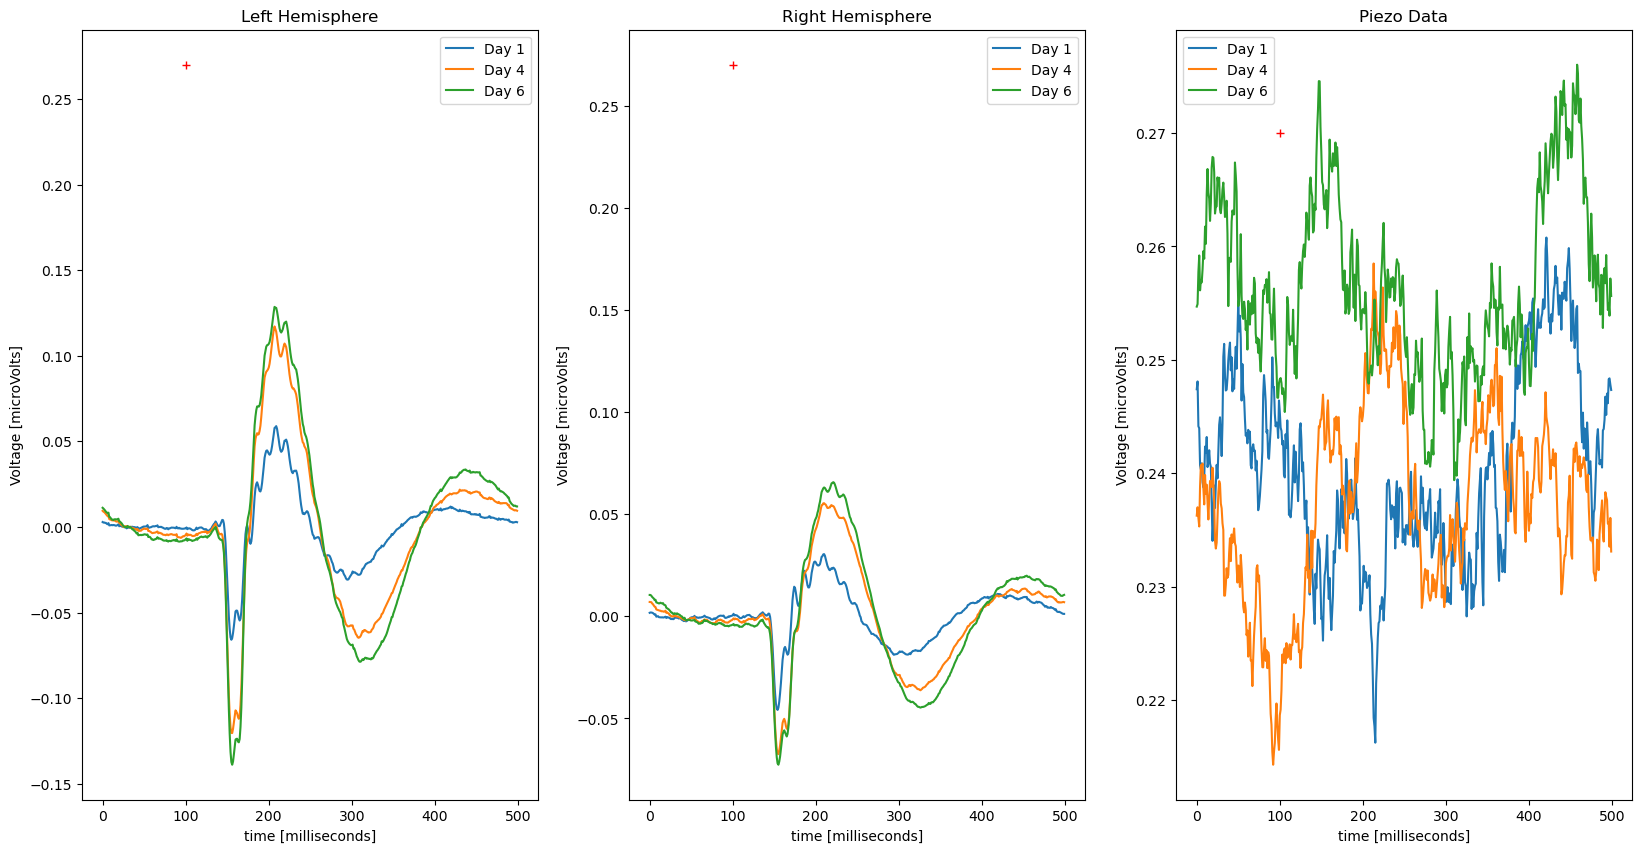

In [39]:
#Plot the means

f, ax = plt.subplots(1,3, figsize=(20,10))

ax = plt.subplot(1,3,1)
plt.plot(strobe_mean_LH_D1)
plt.plot(strobe_mean_LH_D4)
plt.plot(strobe_mean_LH_D6)
plt.legend(['Day 1','Day 4','Day 6'])
#plt.plot(strobe_std_LH[0])
plt.plot(100,.27,'r+')
plt.title("Left Hemisphere")
plt.xlabel('time [milliseconds]')
plt.ylabel('Voltage [microVolts]')

ax = plt.subplot(1,3,2)
plt.plot(strobe_mean_RH_D1)
plt.plot(strobe_mean_RH_D4)
plt.plot(strobe_mean_RH_D6)
plt.legend(['Day 1','Day 4','Day 6'])
#plt.plot(strobe_std_RH[0])
plt.plot(100,.27,'r+')
plt.title("Right Hemisphere")
plt.xlabel('time [milliseconds]')
plt.ylabel('Voltage [microVolts]')

ax = plt.subplot(1,3,3)
plt.plot(strobe_mean_Pz_D1)
plt.plot(strobe_mean_Pz_D4)
plt.plot(strobe_mean_Pz_D6)
plt.legend(['Day 1','Day 4','Day 6'])
#plt.plot(strobe_std_Pz[0])
plt.plot(100,.27,'r+')
plt.title("Piezo Data")
plt.xlabel('time [milliseconds]')
plt.ylabel('Voltage [microVolts]')

### Comparing start vs end of session

In [ ]:
#Start_End Takes the raw data, and provides only the blocks of time where the events occurred
def Start_End(DataIn,Events,Start_Day,End_Day):
    
    #Create the strobe sample blank arrays as real arrays
    Output = []
    for day in range(Start_Day-1,End_Day,1):
        
        #Look over all mice for a given day
        Long_Mice = []
        for mouse in range(0,len(DataIn[day]),1):

            #Put the strobes events into one line for each mouse
            Strobe_Long = np.zeros((len(Events[day][mouse])*500))
            i = 0
            for j in Events[day][mouse]:
                Strobe_Long[i:i+500] = DataIn[day][mouse][int(j*1000)-100:int(j*1000)+400]
                i+=500
            Long_Mice.append(Strobe_Long)
        Output.append(Long_Mice)
   
    return Output

In [681]:
datLH_Arr = Strobe_Long(datLH,Event_Fam,1,6)
datRH_Arr = Strobe_Long(datRH,Event_Fam,1,6)
datPz_Arr = Strobe_Long(datPz,Event_Fam,1,6)

In [700]:
#Get means and standard deviations for the three types

strobe_mean_LH_D1 = datLH_Arr[0][0] #np.mean(np.mean(datLH_Arr[0], axis=0),axis = 0)
#strobe_mean_LH_D4 = np.mean(np.mean(datLH_Arr[3], axis=0),axis = 0)
#strobe_mean_LH_D6 = np.mean(np.mean(datLH_Arr[5], axis=0),axis = 0)
strobe_std_LH = np.std(datLH_Arr[0], axis=0)

strobe_mean_RH_D1 = np.mean(np.mean(datRH_Arr[0], axis=0),axis = 0)
strobe_mean_RH_D4 = np.mean(np.mean(datRH_Arr[3], axis=0),axis = 0)
#strobe_mean_RH_D6 = np.mean(np.mean(datRH_Arr[5], axis=0),axis = 0)
strobe_std_RH = np.std(datRH_Arr[0], axis=0)

strobe_mean_Pz_D1 = np.mean(np.mean(datPz_Arr[0], axis=0),axis = 0)
strobe_mean_Pz_D4 = np.mean(np.mean(datPz_Arr[3], axis=0),axis = 0)
#strobe_mean_Pz_D6 = np.mean(np.mean(datPz_Arr[5], axis=0),axis = 0)
strobe_std_Pz = np.std(datPz_Arr[0], axis=0)



In [ ]:
#Plot the means

f, ax = plt.subplots(1,3, figsize=(20,10))

ax = plt.subplot(1,3,1)
plt.plot(strobe_mean_LH_D1)
#plt.plot(strobe_mean_LH_D4)
#plt.plot(strobe_mean_LH_D6)
plt.legend(['Day 1','Day 4','Day 6'])
#plt.plot(strobe_std_LH[0])
plt.plot(100,.27,'r+')
plt.title("Left Hemisphere")
plt.xlabel('time [milliseconds]')
plt.ylabel('Voltage [microVolts]')

ax = plt.subplot(1,3,2)
plt.plot(strobe_mean_RH_D1)
plt.plot(strobe_mean_RH_D4)
plt.plot(strobe_mean_RH_D6)
plt.legend(['Day 1','Day 4','Day 6'])
#plt.plot(strobe_std_RH[0])
plt.plot(100,.27,'r+')
plt.title("Right Hemisphere")
plt.xlabel('time [milliseconds]')
plt.ylabel('Voltage [microVolts]')

ax = plt.subplot(1,3,3)
plt.plot(strobe_mean_Pz_D1)
plt.plot(strobe_mean_Pz_D4)
plt.plot(strobe_mean_Pz_D6)
plt.legend(['Day 1','Day 4','Day 6'])
#plt.plot(strobe_std_Pz[0])
plt.plot(100,.27,'r+')
plt.title("Piezo Data")
plt.xlabel('time [milliseconds]')
plt.ylabel('Voltage [microVolts]')

In [169]:
#Get means and standard deviations for the three types

strobe_mean_LH_Start_D1 = np.mean(np.mean(datLH_Arr[1][:][0:200], axis=0),axis = 0)
strobe_mean_LH_End_D1 = np.mean(np.mean(datLH_Arr[1][:][-200:-1], axis=0),axis = 0)

strobe_mean_LH_Start_D2 = np.mean(np.mean(datLH_Arr[2][:][0:200], axis=0),axis = 0)
strobe_mean_LH_End_D2 = np.mean(np.mean(datLH_Arr[2][:][-200:-1], axis=0),axis = 0)

strobe_mean_LH_Start_D3 = np.mean(np.mean(datLH_Arr[4][:][0:200], axis=0),axis = 0)
strobe_mean_LH_End_D3 = np.mean(np.mean(datLH_Arr[4][:][-200:-1], axis=0),axis = 0)

strobe_std_LH = np.std(datLH_Arr[0], axis=0)

strobe_mean_LH_Start.shape

(500,)

Text(0, 0.5, 'Voltage [microVolts]')

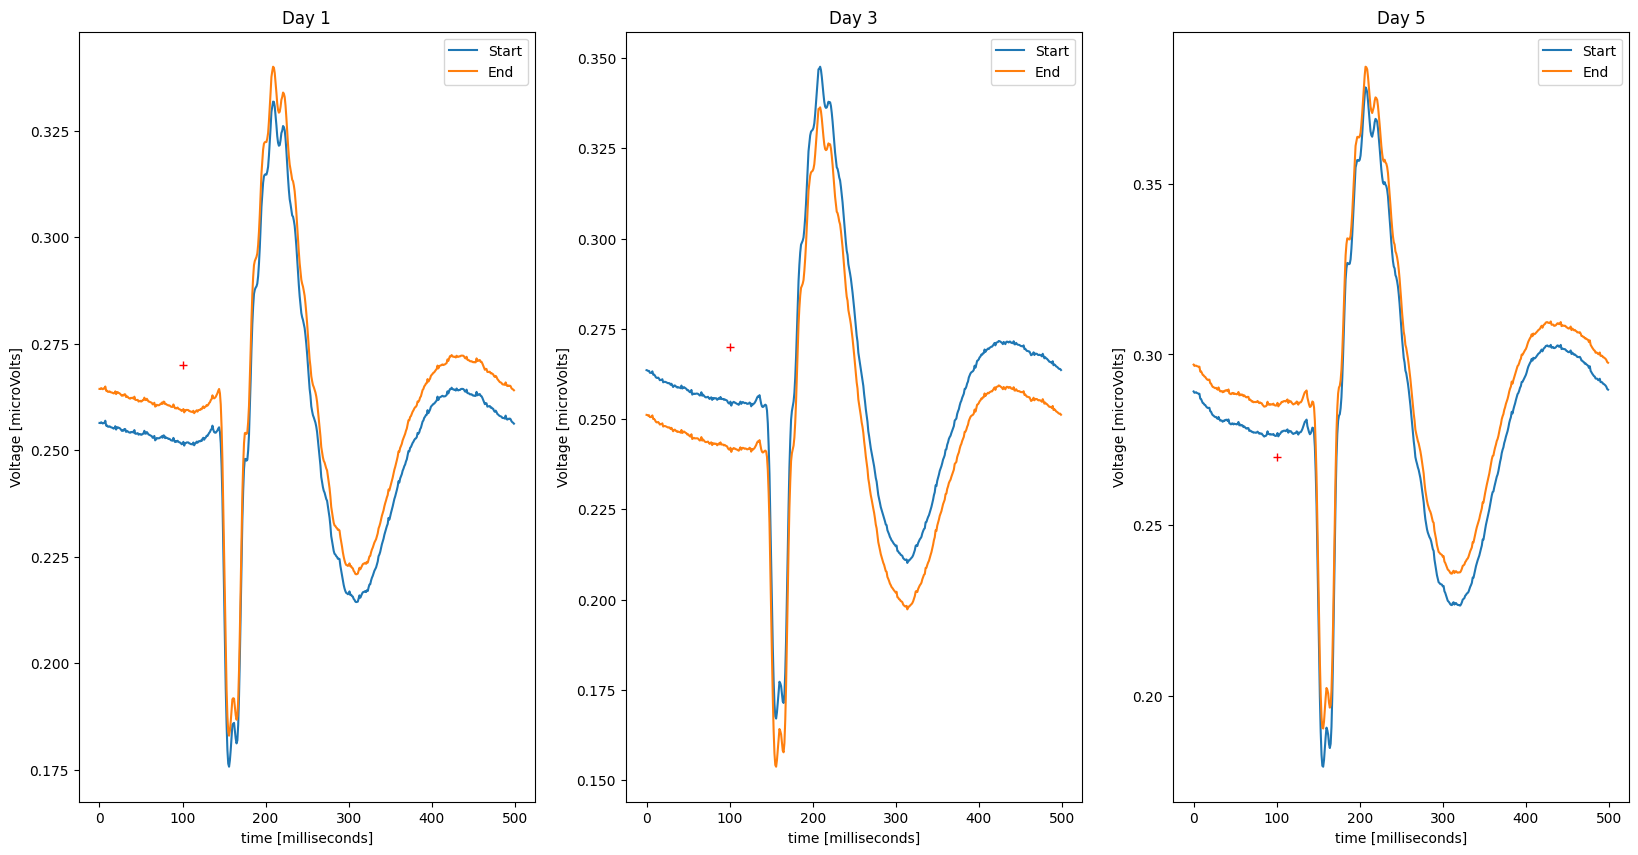

In [170]:
#Plot the means

f, ax = plt.subplots(1,3, figsize=(20,10))

ax = plt.subplot(1,3,1)
plt.plot(strobe_mean_LH_Start_D1)
plt.plot(strobe_mean_LH_End_D1)
plt.legend(['Start','End'])
plt.plot(100,.27,'r+')
plt.title("Day 1")
plt.xlabel('time [milliseconds]')
plt.ylabel('Voltage [microVolts]')

ax = plt.subplot(1,3,2)
plt.plot(strobe_mean_LH_Start_D2)
plt.plot(strobe_mean_LH_End_D2)
plt.legend(['Start','End'])
plt.plot(100,.27,'r+')
plt.title("Day 3")
plt.xlabel('time [milliseconds]')
plt.ylabel('Voltage [microVolts]')

ax = plt.subplot(1,3,3)
plt.plot(strobe_mean_LH_Start_D3)
plt.plot(strobe_mean_LH_End_D3)
plt.legend(['Start','End'])
plt.plot(100,.27,'r+')
plt.title("Day 5")
plt.xlabel('time [milliseconds]')
plt.ylabel('Voltage [microVolts]')

### Fourier Transforms with Plots

#### Piezo

624530


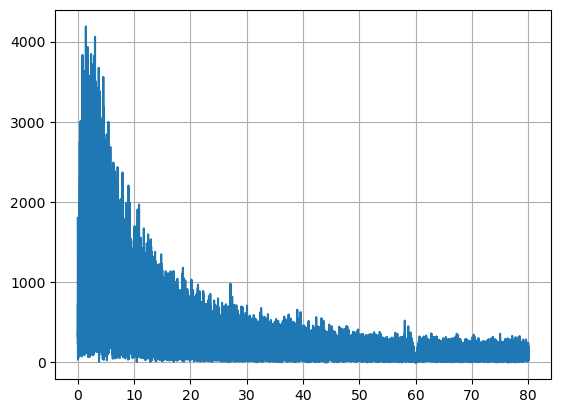

In [13]:
#Strobe_Longest converts the raw data into the strobed events including gray time
#PIEZO TIME
start = 1
end = 3
Pz_Fam_Longest = Strobe_Longest(datPz,Event_Fam,start,end)
len(Pz_Fam_Longest[1][1])
#Get the means
Pz_Fam_Meanest = np.mean(Pz_Fam_Longest[0][:], axis=0) #LH_Fam_Long[day][mice], so LH_Fam_Long[0][:] is all day 1 mice
print(len(Pz_Fam_Meanest))

fs = 1000    # Sampling rate (.5 kHZ based on nyquist theorem)

# Get real amplitudes of FFT (only in postive frequencies)
fft_vals = np.absolute(np.fft.rfft(Pz_Fam_Meanest))

# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(Pz_Fam_Meanest), 1.0/fs)

#yf = scp.fft.rfft(LH_D1_Long_Mean)

# Number of sample points

plt.plot(fft_freq[1:50000],fft_vals[1:50000])
plt.grid()
plt.show()

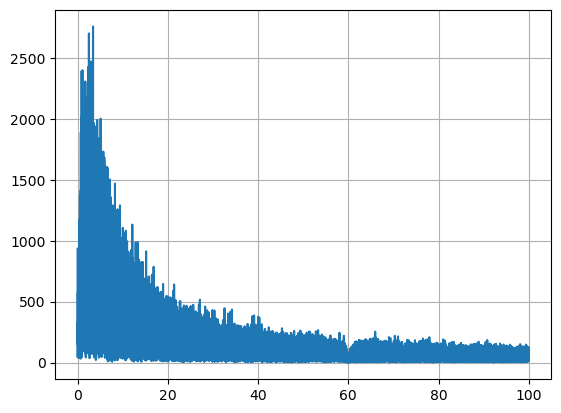

In [8]:
#Strobe_Long converts the raw data into just the strobed events, still in 3D, not split by strobes
start = 1
end = 6
Pz_Fam_Long = Strobe_Long(datPz,Event_Fam,start,end)

#Get the means
Pz_Fam_Mean = np.mean(np.mean(Pz_Fam_Long[1:3][:], axis=0), axis=0) #LH_Fam_Long[day][mice], so LH_Fam_Long[0][:] is all day 1 mice
len(Pz_Fam_Mean)

fs = 1000    # Sampling rate (.5 kHZ based on nyquist)

# Get real amplitudes of FFT (only in postive frequencies)
fft_vals = np.absolute(np.fft.rfft(Pz_Fam_Mean))

# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(Pz_Fam_Mean), 1.0/fs)

#yf = scp.fft.rfft(LH_D1_Long_Mean)

# Number of sample points

plt.plot(fft_freq[1:50000],fft_vals[1:50000])
plt.grid()
plt.show()

How does the continuous movement data interact
* Look at the difference in slow wave movement of data
* Examine the whole signal, put in a low pass filter to get an average data for each
* See whether when they move more or less

#### Left Hemisphere

[array([-0.08223582, -0.09240245, -0.12215917, ..., -0.05311217,
       -0.03086387,  0.01078768]), array([ 0.07825606,  0.07103826,  0.08331248, ..., -0.34176113,
       -0.35883699, -0.34174837]), array([ 0.20276995,  0.21233175,  0.20480538, ..., -0.08556956,
       -0.08794707, -0.08544205]), array([ 0.11706122,  0.10735777,  0.08056849, ..., -0.04142371,
       -0.02928067, -0.02935031]), array([-0.02448202, -0.0440412 , -0.07823781, ..., -0.20516132,
       -0.12942565, -0.09031107]), array([0.06318776, 0.06083297, 0.08536918, ..., 0.20014228, 0.20255468,
       0.20254633]), array([-0.08529754, -0.12191288, -0.10971895, ...,  0.1900634 ,
        0.1585348 ,  0.12947306]), array([-0.0413247 , -0.00244397,  0.04131636, ...,  0.06835645,
        0.04159552,  0.03678809]), array([-0.31377361, -0.33351149, -0.28466906, ...,  0.02619158,
        0.04323089,  0.05061795]), array([-0.0464236 , -0.07080906, -0.05612285, ...,  0.14670732,
        0.09058879,  0.05397186])]
624530


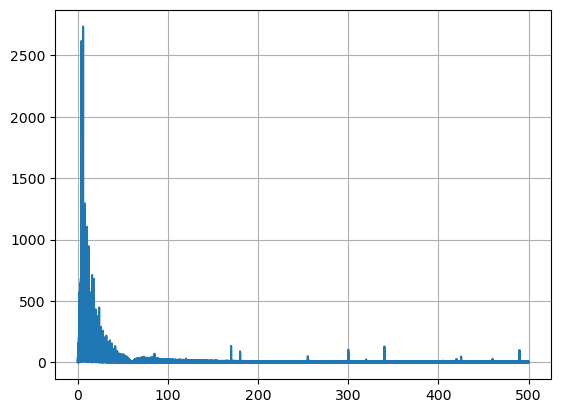

In [7]:
#Strobe_Longest converts the raw data into the strobed events including gray time
start = 1
end = 1
LH_Fam_Longest = Strobe_Longest(datLH,Event_Fam,start,end)
print(LH_Fam_Longest[0])
#Get the means
LH_Fam_Meanest = np.mean(np.mean(LH_Fam_Longest[0:1][:], axis=0), axis=0) #LH_Fam_Long[day][mice], so LH_Fam_Long[0][:] is all day 1 mice
print(len(LH_Fam_Meanest))

fs = 1000  

# Get real amplitudes of FFT (only in postive frequencies)
fft_vals = np.absolute(np.fft.rfft(LH_Fam_Meanest))

# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(LH_Fam_Meanest), 1.0/fs)

#yf = scp.fft.rfft(LH_D1_Long_Mean)

# Number of sample points

plt.plot(fft_freq,fft_vals)
plt.grid()
plt.show()

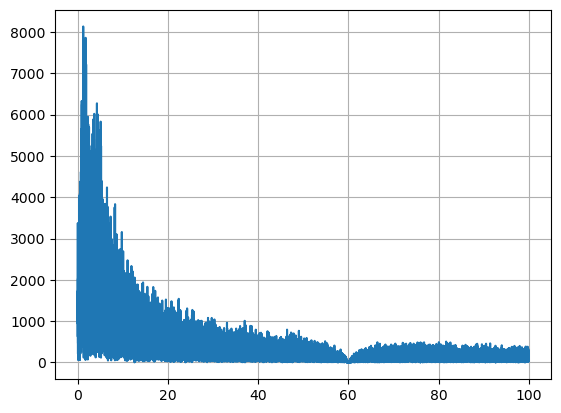

In [36]:
#Strobe_Long converts the raw data into just the strobed events, still in 3D, not split by strobes
start = 1
end = 1
LH_Fam_Long = Strobe_Long(datPz,Event_Fam,start,end)

#Get the means
LH_Fam_Mean = np.mean(np.mean(LH_Fam_Long[0:1][:], axis=0), axis=0) #LH_Fam_Long[day][mice], so LH_Fam_Long[0][:] is all day 1 mice
len(LH_Fam_Mean)



fs = 1000    # Sampling rate (.5 kHZ based on nyquist)

# Get real amplitudes of FFT (only in postive frequencies)
fft_vals = np.absolute(np.fft.rfft(LH_Fam_Mean))

# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(LH_Fam_Mean), 1.0/fs)


#Plot the means
plt.plot(fft_freq[1:50000],fft_vals[1:50000])
plt.grid()




In [ ]:
# Break out into frequency bands 


## Creating a Data Frame
DataFrame Cheat Sheet: https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf

In [86]:
# Gets the peak value given a data block and event time, returns peak and peak time
def Peak_Finder(DataIn, event_time):
    
    Data = DataIn[event_time-100:event_time+400]
    Peak = np.max(Data) - np.min(Data)
    Peak_Time = np.argmax(Data) + event_time - 100

    return Peak,Peak_Time
    

In [88]:
columns = ['Measure', 'Day', 'Mouse','Stim Num', 'Stim Type', 'Stim Time', 'Peak Time', 'Peak']
#Starting with datLH

##MEASURE
Measure = 0
Peak_DF = pd.DataFrame()
i = 0
#DAY
for Day in range(0,2,1): 
    
    #MOUSE
    for Mouse in range(0,len(datLH[Day]),1): 
        print(f'Day: {Day+1}, Mouse: {Mouse+1}')
        #STIM TYPE Familiar
        Stim_Type = 0
        for j in range(0,len(Event_Fam[Day][Mouse]),1):
            Event_Time = int(Event_Fam[Day][Mouse][j]*1000)
            ##PEAK
            Peak, Peak_Time = Peak_Finder(datLH[Day][Mouse],Event_Time)
            Peak_Series = pd.Series(data = [Measure, Day+1, Mouse+1,j+1, Stim_Type, Event_Time, Peak_Time, Peak], index = columns, name = i)
            Peak_DF = pd.concat([Peak_DF,Peak_Series.to_frame().T],ignore_index=False)
            i = i+1

        #STIM TYPE Novel
        Stim_Type = 1
        for j in range(0,len(Event_Nov[Day][Mouse]),1):
            Event_Time = int(Event_Nov[Day][Mouse][j]*1000)
            ##PEAK
            Peak, Peak_Time = Peak_Finder(datLH[Day][Mouse],Event_Time)
            Peak_Series = pd.Series(data = [Measure, Day+1, Mouse+1,j+1, Stim_Type, Event_Time, Peak_Time, Peak], index = columns, name = i)
            Peak_DF = pd.concat([Peak_DF,Peak_Series.to_frame().T],ignore_index=False)
            i = i+1  


Day: 1, Mouse: 1
Day: 1, Mouse: 2
Day: 1, Mouse: 3
Day: 1, Mouse: 4
Day: 1, Mouse: 5
Day: 1, Mouse: 6
Day: 1, Mouse: 7
Day: 1, Mouse: 8
Day: 1, Mouse: 9
Day: 1, Mouse: 10
Day: 1, Mouse: 11
Day: 1, Mouse: 12
Day: 1, Mouse: 13
Day: 1, Mouse: 14
Day: 1, Mouse: 15
Day: 1, Mouse: 16
Day: 1, Mouse: 17
Day: 1, Mouse: 18
Day: 1, Mouse: 19
Day: 1, Mouse: 20
Day: 1, Mouse: 21
Day: 1, Mouse: 22
Day: 1, Mouse: 23
Day: 1, Mouse: 24
Day: 1, Mouse: 25
Day: 1, Mouse: 26
Day: 1, Mouse: 27
Day: 1, Mouse: 28
Day: 1, Mouse: 29
Day: 1, Mouse: 30
Day: 1, Mouse: 31
Day: 1, Mouse: 32
Day: 1, Mouse: 33
Day: 1, Mouse: 34
Day: 2, Mouse: 1
Day: 2, Mouse: 2
Day: 2, Mouse: 3
Day: 2, Mouse: 4
Day: 2, Mouse: 5
Day: 2, Mouse: 6
Day: 2, Mouse: 7
Day: 2, Mouse: 8
Day: 2, Mouse: 9
Day: 2, Mouse: 10
Day: 2, Mouse: 11
Day: 2, Mouse: 12
Day: 2, Mouse: 13
Day: 2, Mouse: 14
Day: 2, Mouse: 15
Day: 2, Mouse: 16
Day: 2, Mouse: 17
Day: 2, Mouse: 18
Day: 2, Mouse: 19
Day: 2, Mouse: 20
Day: 2, Mouse: 21
Day: 2, Mouse: 22
Day: 2, Mo

In [ ]:
# USE TO APPEND DATA
#Starting with datLH

##MEASURE
Measure = 'Left Hemisphere'
Peak_DF = pd.DataFrame()
#DAY
for Day in range(4,7,1): 
    
    #MOUSE
    for Mouse in range(0,len(datLH[Day]),1): 
        print(f'Day: {Day+1}, Mouse: {Mouse+1}')
        #STIM TYPE Familiar
        Stim_Type = 'Familiar'
        for j in range(0,len(Event_Fam[Day][Mouse]),1):
            Event_Time = int(Event_Fam[Day][Mouse][j]*1000)
            ##PEAK
            Magnitude, Peak_Time = Peak_Finder(datLH[Day][Mouse],Event_Time)
            Peak_Series = pd.Series(data = [Measure, Day+1, Mouse+1,j+1, Stim_Type, Event_Time, Peak_Time, Peak], index = columns, name = i)
            Peak_DF = pd.concat([Peak_DF,Peak_Series.to_frame().T],ignore_index=False)
            i = i+1

        #STIM TYPE Novel
        Stim_Type = 'Novel'
        for j in range(0,len(Event_Nov[Day][Mouse]),1):
            Event_Time = int(Event_Nov[Day][Mouse][j]*1000)
            ##PEAK
            Peak, Peak_Time = Peak_Finder(datLH[Day][Mouse],Event_Time)
            Peak_Series = pd.Series(data = [Measure, Day+1, Mouse+1,j+1, Stim_Type, Event_Time, Peak_Time, Peak], index = columns, name = i)
            Peak_DF = pd.concat([Peak_DF,Peak_Series.to_frame().T],ignore_index=False)
            i = i+1  


In [ ]:
#Run datRH when ready

##MEASURE
Measure = 'Right Hemisphere'
#DAY
for Day in range(0,len(datRH),1): 
    
    #MOUSE
    for Mouse in range(0,len(datRH[Day]),1): 
        print(f'Day: {Day+1}, Mouse: {Mouse+1}')
        #STIM TYPE Familiar
        Stim_Type = 'Familiar'
        for j in range(0,len(Event_Fam[Day][Mouse]),1):
            Event_Time = int(Event_Fam[Day][Mouse][j]*1000)
            ##PEAK
            Peak, Peak_Time = Peak_Finder(datRH[Day][Mouse],Event_Time)
            Peak_Series = pd.Series(data = [Measure, Day+1, Mouse+1,j+1, Stim_Type, Event_Time, Peak_Time, Peak], index = columns, name = i)
            Peak_DF = pd.concat([Peak_DF,Peak_Series.to_frame().T],ignore_index=False)
            i = i+1

        #STIM TYPE Novel
        Stim_Type = 'Novel'
        for j in range(0,len(Event_Nov[Day][Mouse]),1):
            Event_Time = int(Event_Nov[Day][Mouse][j]*1000)
            ##PEAK
            Peak, Peak_Time = Peak_Finder(datRH[Day][Mouse],Event_Time)
            Peak_Series = pd.Series(data = [Measure, Day+1, Mouse+1,j+1, Stim_Type, Event_Time, Peak_Time, Peak], index = columns, name = i)
            Peak_DF = pd.concat([Peak_DF,Peak_Series.to_frame().T],ignore_index=False)
            i = i+1  


In [89]:
# Create a block column and a Diff Column
if 'Block' not in Peak_DF:
    Peak_DF.insert(loc=4, column = 'Block',value=0)

if 'Diff' not in Peak_DF:
    Peak_DF.insert(loc=7, column = 'Diff',value=0)

#Sort accordingly, so novel is intermingled as well
Peak_DF = Peak_DF.sort_values(by=['Measure', 'Day', 'Mouse', 'Stim Time'], ascending=[False,True,True,True])
Peak_DF["Diff"] = Peak_DF.groupby(['Measure', 'Day', 'Mouse'])['Stim Time'].diff()

#Increment the block for each day/mouse, so we can look at the Nth block for all mice on day X
Grouped = Peak_DF.groupby(['Measure', 'Day', 'Mouse'])
for Group_Name, Group in Grouped:
    Block = 1
    for row_index, row in Group.iterrows():
        if not Peak_DF.iat[row_index,7] >= 1000:
            Peak_DF.iat[row_index,4] = Block
            Peak_DF.iat[row_index,3] = (Peak_DF.iat[row_index,3]-1)%200
        else:
            Block = Block+1
            Peak_DF.iat[row_index,4] = Block
            Peak_DF.iat[row_index,3] = (Peak_DF.iat[row_index,3]-1)%200

del Peak_DF['Diff'] #Cleanup, delete Diff it's not important anymore

In [97]:
Peak_DF

,Measure,Day,Mouse,Stim Num,Block,Stim Type,Stim Time,Peak Time,Peak
0,0.0,1.0,1.0,0.0,1,0.0,306317.0,306430.0,0.584781
1,0.0,1.0,1.0,1.0,1,0.0,306817.0,306861.0,0.437201
2,0.0,1.0,1.0,2.0,1,0.0,307317.0,307361.0,0.571070
3,0.0,1.0,1.0,3.0,1,0.0,307817.0,308182.0,0.607064
4,0.0,1.0,1.0,4.0,1,0.0,308316.0,308421.0,0.529504
...,...,...,...,...,...,...,...,...,...
68995,0.0,2.0,35.0,195.0,5,0.0,930661.0,930734.0,0.729847
68996,0.0,2.0,35.0,196.0,5,0.0,931167.0,931137.0,0.573277
68997,0.0,2.0,35.0,197.0,5,0.0,931672.0,931904.0,0.907503
68998,0.0,2.0,35.0,198.0,5,0.0,932178.0,932364.0,1.601835


In [127]:
#TEST
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re

scaler = StandardScaler()
T1_masked_std = scaler.fit_transform(Peak_DF)
X = T1_masked_std

# Run PCA with 50 components
pca = PCA(n_components=10) # Specify how many components will be calculated
pca.fit(Peak_DF);
X_reduced = pca.transform(Peak_DF) # calculate the component scores for the components

# Explained variance plot, in red
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(pca.explained_variance_ratio_,'r')
ax.set_xlabel("Component number", fontsize=14)
ax.set_ylabel("Explained variance", color="r", fontsize=14);

# Cumulative explained variance plot, in blue
ax2=ax.twinx()
ax2.plot(np.cumsum(pca.explained_variance_ratio_),'b')
ax2.set_ylabel("Cumulative explained variance", color="blue", fontsize=14);

ValueError: n_components=10 must be between 0 and min(n_samples, n_features)=9 with svd_solver='full'

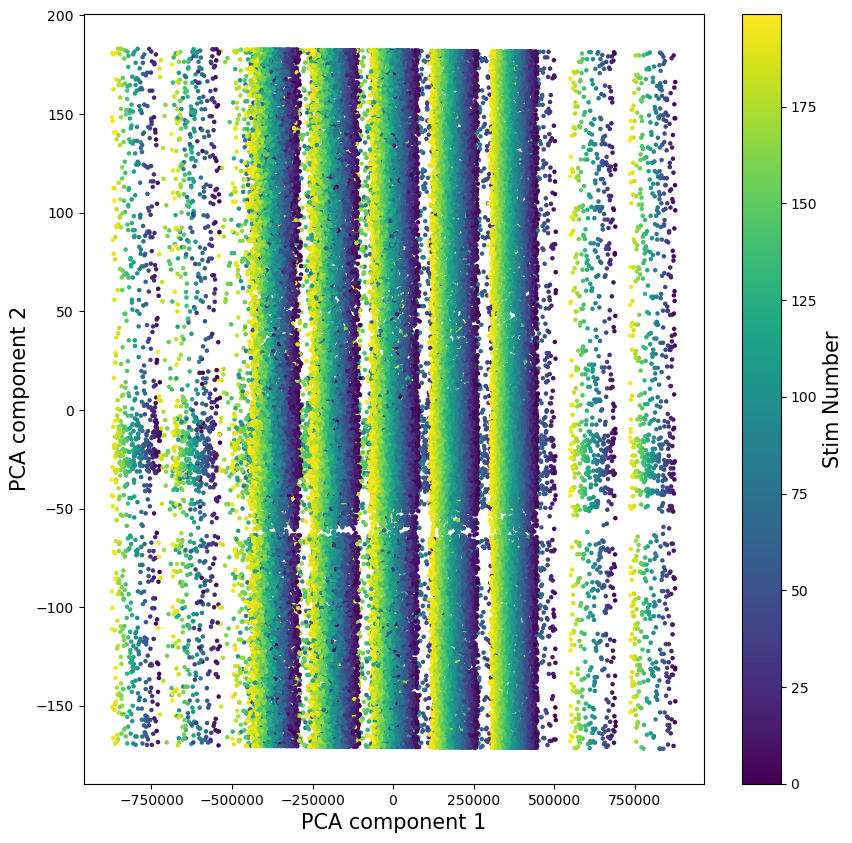

In [125]:
# choose two components to plot
cp_x = 0 # x-axis
cp_y = 1 # y-axis

fig = plt.figure(figsize=(10, 10))
plt.scatter(X_reduced[:,cp_x], X_reduced[:,cp_y], c=Peak_DF['Stim Num'], s=5) # you can vary the indices to plot a different pair of components
plt.xlabel(f'PCA component {cp_x+1}', fontsize=15) # add 1 to the label due to Python
plt.ylabel(f'PCA component {cp_y+1}', fontsize=15) # add 1 due to Python
cbar = plt.colorbar();                             # add a colorbar
cbar.set_label('Stim Number', fontsize=15)         # add a colorbar label

## Analyzing Data Frame

### Change over a phase block
Focus on Day 1
* Get the mean and SD of all stim 1 peaks, followed by all final stim peaks for the first block in a day

<BarContainer object of 3 artists>

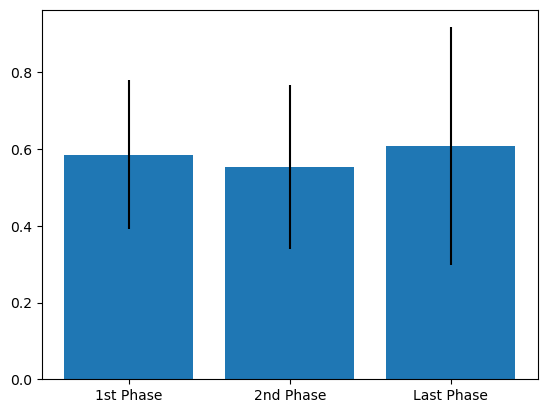

In [341]:
#Focus on Day 1, get the mean and standard deviation 
Filt_Start_Phase = (Peak_DF['Day'] == 1)&(Peak_DF['Stim Num'] == 0)
Filt_Second_Phase = (Peak_DF['Day'] == 1)&(Peak_DF['Stim Num'] == 1)
Filt_End_Phase = (Peak_DF['Day'] == 1)&(Peak_DF['Stim Num'] == 199)

Start_Phase = Peak_DF[Filt_Start_Phase]['Peak'].mean()
Start_Phase_STD = Peak_DF[Filt_Start_Phase]['Peak'].std()

Sec_Phase = Peak_DF[Filt_Second_Phase]['Peak'].mean()
Sec_Phase_STD = Peak_DF[Filt_Second_Phase]['Peak'].std()

End_Phase = Peak_DF[Filt_End_Phase]['Peak'].mean()
End_Phase_STD = Peak_DF[Filt_End_Phase]['Peak'].std()

plt.bar(['1st Phase','2nd Phase','Last Phase'],[Start_Phase,Sec_Phase,End_Phase],yerr=[Start_Phase_STD,Sec_Phase_STD,End_Phase_STD],label = 'Left Hemisphere Phase Change')



### Change over a day/session

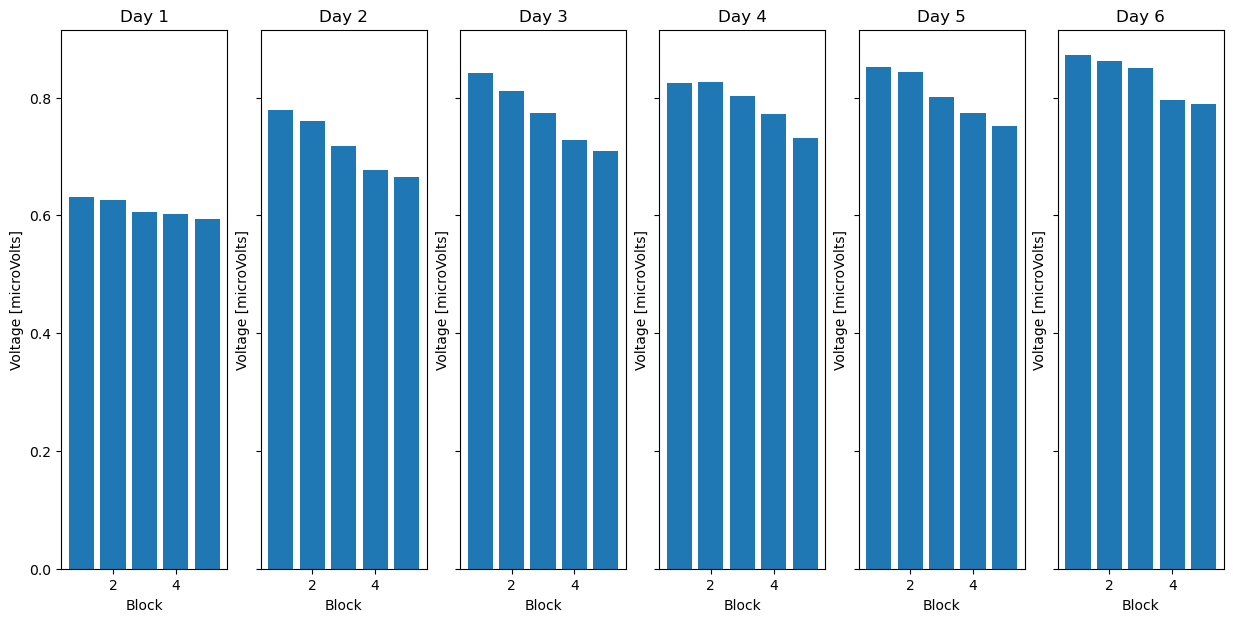

In [351]:
# Looking across days

Block_Means = np.zeros([7,5])
Block_STDs = np.zeros([7,5])

for day in range(1,8,1):
    for block in range(1,6,1):
        Filter = (Peak_DF['Stim Type'] == 'Familiar')&(Peak_DF['Block'] == block)&(Peak_DF['Day']==day)
        
        Block_Means[day-1][block-1] = Peak_DF[Filter]['Peak'].mean()
        
        Block_STDs[day-1][block-1] = Peak_DF[Filter]['Peak'].std()



End_Phase = Peak_DF[Filt_End_Phase]['Peak'].mean()
End_Phase_STD = Peak_DF[Filt_End_Phase]['Peak'].std()

#plt.bar(['Block 1','Block 2','Block 3','Block 4','Block 5'],Block_Means,yerr=Block_STDs,label = 'Left Hemisphere Phase Change')

f, ax = plt.subplots(1,6, figsize=(15,7),sharey=True)

for i in range(0,6,1):
    ax = plt.subplot(1,6,i+1)
    plt.bar([1,2,3,4,5],Block_Means[i],label = 'Left Hemisphere Phase Change')
    plt.title(f'Day {i+1}')
    plt.xlabel('Block')
    plt.ylabel('Voltage [microVolts]')




### Change over multiple days

<BarContainer object of 2 artists>

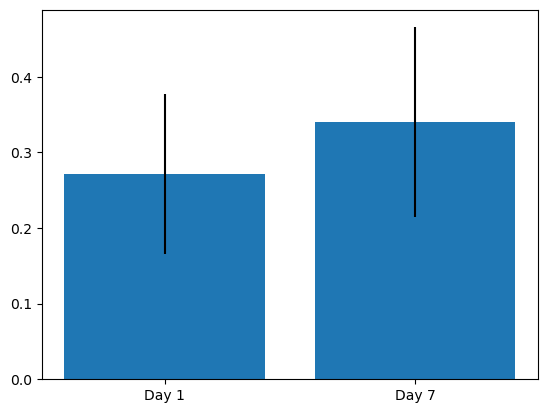

In [260]:
#Create the filter
Filt_Start_Phase = (Peak_DF['Stim Type'] == 'Familiar')&(Peak_DF['Day'] == 1)
Filt_End_Phase = (Peak_DF['Stim Type'] == 'Familiar')&(Peak_DF['Day'] == 7)
#Apply the filter
Start_Phase = Peak_DF[Filt_Start_Phase]['Peak'].mean()
Start_Phase_STD = Peak_DF[Filt_Start_Phase]['Peak'].std()

End_Phase = Peak_DF[Filt_End_Phase]['Peak'].mean()
End_Phase_STD = Peak_DF[Filt_End_Phase]['Peak'].std()

plt.bar(['Day 1','Day 7'],[Start_Phase,End_Phase],yerr=[Start_Phase_STD,End_Phase_STD],label = 'Left Hemisphere Phase Change')



### Novel Stim: Change over a phase block

In [82]:
#Create the filter
Filt_Start_Phase = (Peak_DF['Stim Type'] == 'Familiar')&(Peak_DF['Day'] == 7)&(Peak_DF['Stim Num'] == 1)
Filt_End_Phase = (Peak_DF['Stim Type'] == 'Familiar')&(Peak_DF['Day'] == 7)&(Peak_DF['Stim Num'] == 199)

#Apply the filter
Start_Phase = Peak_DF[Filt_Start_Phase]['Peak'].mean()
Start_Phase_STD = Peak_DF[Filt_Start_Phase]['Peak'].std()

End_Phase = Peak_DF[Filt_End_Phase]['Peak'].mean()
End_Phase_STD = Peak_DF[Filt_End_Phase]['Peak'].std()

plt.bar(['Day 1','Day 7'],[Start_Phase,End_Phase],yerr=[Start_Phase_STD,End_Phase_STD],label = 'Left Hemisphere Phase Change')


NameError: name 'Peak_DF' is not defined

### Novel Stim: Change over a day/session

# Old Notes for lookback

## Smoothing Efforts with Plots
* This has since been added to the main import piece

Text(0, 0.5, 'Voltage [microVolts]')

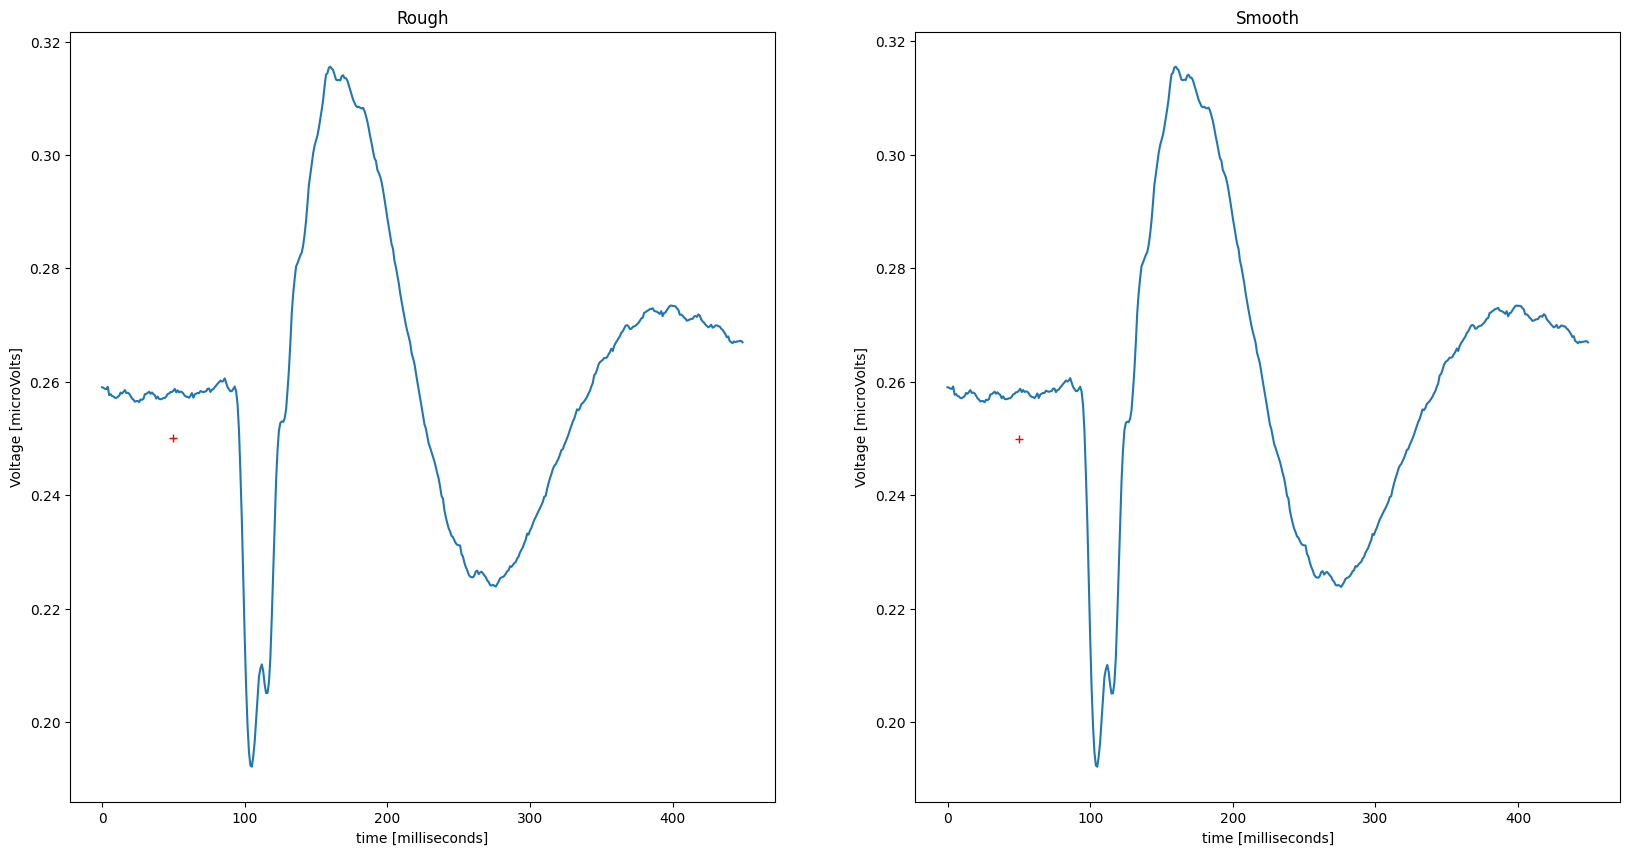

In [748]:
Fam_LH_Split = Strobe_Split(datRH,Event_Fam,1,6)

#Get means and standard deviations

Fam_LH_Mean_Rough = np.mean(np.mean(Fam_LH_Split[3], axis=0),axis=0)

#Smoothing
Notcha,Notchb = scp.signal.iirnotch(60, 500, fs=1000)
Fam_LH_Butter = scp.signal.filtfilt(Notcha,Notchb,Fam_LH_Mean_Rough)
#Nov_LH_Mean = np.mean(Nov_LH_Split, axis=0)

#Fix later: strobe_std_LH = np.std(datLH_Arr[0], axis=0)

#Plot the means

f, ax = plt.subplots(1,2, figsize=(20,10))
CUT=50
ax = plt.subplot(1,2,1)
plt.plot(Fam_LH_Mean_Rough[CUT:])
#plt.plot(Nov_LH_Mean)
#plt.legend(['Rough','Smooth'])

plt.plot(100-CUT,.25,'r+')
plt.title("Rough")
plt.xlabel('time [milliseconds]')
plt.ylabel('Voltage [microVolts]')

ax = plt.subplot(1,2,2)
plt.plot(Fam_LH_Butter[CUT:])
#plt.plot(Nov_LH_Mean)
#plt.legend(['Rough','Smooth'])

plt.plot(100-CUT,.25,'r+')
plt.title("Smooth")
plt.xlabel('time [milliseconds]')
plt.ylabel('Voltage [microVolts]')


## Misc

In [152]:
#ARRAY STYLE Look through each day, storing it as datLH[Day #][Mouse #][Strobe #][Data] to allow comparing days

start_time = time.time()

os.listdir("CBSC")
days = 5
if days >= 7:
    days = 6

datLH_Arr = np.zeros((days, 35, 1236, 500))
datRH_Arr = np.copy(datLH_Arr)
datPz_Arr = np.copy(datLH_Arr)

for i in range(1,days+1,1):
    files = os.listdir("CBSC/day " + str(i) + "/")

    #Creates three files, one for each reading type, split for each file (mouse)
    j = 0
    for file in files:
        fname = "CBSC/day " + str(i) + "/" + file #Concatenate directory with file path to be able to run the function over all days
        datLH_Arr[i-1][j][:][:],datRH_Arr[i-1][j][:][:],datPz_Arr[i-1][j][:][:] = plexon_array(fname)
        j += 1

print(f'The shape of datLH_Days is: {datLH_Arr.shape}')

print("--- %s seconds ---" % (time.time() - start_time)) #Just to see how long it takes

The shape of datLH_Days is: (5, 35, 1236, 500)
--- 107.81672215461731 seconds ---


In [5]:
#ARRAY STYLE Function to pull in the data for a given file ARRAY Style
def plexon_array(filepath):
    
    reader = neo.PlexonIO(filepath)
    blks = reader.read()
    seg = blks[0].segments[0]
    seg.data_children

    #Get analog signal
    sig = seg.analogsignals[0]
    
    #Each sig index is one millisecond, but need to sort out the multiple channel issue
    sigLH = sig[:,0] #Left Hemisphere
    sigRH = sig[:,1] #Right Hemisphere
    sigPz = sig[:,2] #Piezo Data
    
    #Extract data and time series to use
    datLH = sigLH.data
    datRH = sigRH.data
    datPz = sigPz.data

    #Reshape data so it's just a 1-D array so it can plot
    shape = datLH.shape[0] #shape shouldn't change
    datLH = np.reshape(datLH,(shape)) 
    datRH = np.reshape(datRH,(shape)) 
    datPz = np.reshape(datPz,(shape)) 
    
    #Event_times stores the time each strobe event occured
    event_times = [e.times for e in seg.events]
    
    #Create the strobe sample blank arrays as real arrays
    strobe_split_LH = np.zeros((1236,500))
    strobe_split_RH = np.copy(strobe_split_LH)
    strobe_split_Pz = np.copy(strobe_split_LH)
    #Testing: print(f'shape of strobe_split_LH as the raw data: {strobe_split_LH.shape}')
    
    #For each strobe event, pick the 500 samples at that time point
    i = 0
    for j in event_times[3][0:1235]:
        strobe_split_LH[i,:] = datLH[int(j*1000)-100:int(j*1000)+400]
        strobe_split_RH[i,:] = datRH[int(j*1000)-100:int(j*1000)+400]
        strobe_split_Pz[i,:] = datPz[int(j*1000)-100:int(j*1000)+400]
        i += 1
    
    #Testing: print(f'shape of strobe_split_LH as the updated data: {strobe_split_LH.shape}')    
    
    #Time series should be repeatable for each scenario does the time series matter? Probably not no
    #t_axisLH = sigLH.times
    #t_axisRH = sigRH.times
    #t_axisPz = sigPz.times

    return strobe_split_LH,strobe_split_RH,strobe_split_Pz


In [3]:
#Function to pull in the data for a given file
def plexon_import(filepath):
    
    reader = neo.PlexonIO(filepath)
    blks = reader.read()
    seg = blks[0].segments[0]
    seg.data_children

    #Get analog signal
    sig = seg.analogsignals[0]
    
    #Each sig index is one millisecond, but need to sort out the multiple channel issue
    sigLH = sig[:,0] #Left Hemisphere
    sigRH = sig[:,1] #Right Hemisphere
    sigPz = sig[:,2] #Piezo Data
    
    #Extract data and time series to use
    datLH = sigLH.data
    datRH = sigRH.data
    datPz = sigPz.data

    #Reshape data so it's just a 1-D array so it can plot
    shape = datLH.shape[0] #shape shouldn't change
    datLH = np.reshape(datLH,(shape)) 
    datRH = np.reshape(datRH,(shape)) 
    datPz = np.reshape(datPz,(shape)) 

    #Event_times stores the time each strobe event occured
    event_times = [e.times for e in seg.events]
    
    #Create the strobe sample blank arrays
    strobe_split_LH = []
    strobe_split_RH = []
    strobe_split_Pz = []

    #For each strobe event, pick the 500 samples at that time point
    for j in event_times[3]:
        strobe_split_LH.extend([datLH[int(j*1000)-100:int(j*1000)+400]])
        strobe_split_RH.extend([datRH[int(j*1000)-100:int(j*1000)+400]])
        strobe_split_Pz.extend([datPz[int(j*1000)-100:int(j*1000)+400]])
    
    #Time series should be repeatable for each scenario does the time series matter? Probably not no
    #t_axisLH = sigLH.times
    #t_axisRH = sigRH.times
    #t_axisPz = sigPz.times

    return strobe_split_LH,strobe_split_RH,strobe_split_Pz


In [158]:
#Can be move to error pile?
#Function to Convert into a list of each strobe event rather than split by each mouse
def resort_list(Ugly_List):
    num_files = len(Ugly_List)
    Pretty_List = []
    for i in range(0,num_files,1):
        num_strobes = len(Ugly_List[i])
        for j in range(0,num_strobes,1):
            Pretty_List.append(Ugly_List[i][j])
    
    return Pretty_List


In [ ]:
#Look through each day, storing it as datLH[Day #][Strobe #] to allow comparing days
#THIS IS in list format
start_time = time.time()

os.listdir("CBSC")
datLH_Days = []
datRH_Days = []
datPz_Days = []
for i in range(1,7,1):
    files = os.listdir("CBSC/day " + str(i) + "/")
    
    #Create empty lists
    datLH_MiceDay = []
    datRH_MiceDay = []
    datPz_MiceDay = []
    
    #Creates three files, one for each reading type, split for each file (mouse)
    for file in files:
        fname = "CBSC/day " + str(i) + "/" + file #Concatenate directory with file path to be able to run the function over all days
        datLH_int,datRH_int,datPz_int = plexon_import(fname)
        datLH_MiceDay.append(datLH_int)
        datRH_MiceDay.append(datRH_int)
        datPz_MiceDay.append(datPz_int)

    datLH_Days.append(datLH_MiceDay)
    datRH_Days.append(datRH_MiceDay)
    datPz_Days.append(datPz_MiceDay)
    #Convert the lists from being split by mouse into a single list
    #datLH_1Line = [a for b in datLH_MiceDay for a in b]
    #datRH_1Line = [a for b in datRH_MiceDay for a in b]
    #datPz_1Line = [a for b in datPz_MiceDay for a in b]
print(f'The shape of datLH_Days is:  {len(datLH_Days)},{len(datLH_Days[0])},{len(datLH_Days[0][0])},{len(datLH_Days)},')
print("--- %s seconds ---" % (time.time() - start_time)) #Just to see how long it takes

In [244]:
#This finds files within this folder, i.e. 'day 1' folder is in the same folder as this script
files = os.listdir("day 1")

#Create empty lists
datLH_spl = []
datRH_spl = []
datPz_spl = []

#Creates three files, one for each reading type, split for each file (mouse)
for file in files:
    fname = "day 1/" + file #Concatenate directory with file path to be able to run the function over all days
    str_spl_LH,str_spl_RH,str_spl_Pz = plexon_import(fname)
    datLH_spl.append(str_spl_LH)
    datRH_spl.append(str_spl_RH)
    datPz_spl.append(str_spl_Pz)

#Convert the lists from being split by mouse into a single list
datLH = resort_list(datLH_spl)
datRH = resort_list(datRH_spl)
datPz = resort_list(datPz_spl)


In [186]:
#Reads the Plexon file into seg
reader = neo.PlexonIO(fname)
blks = reader.read()
seg = blks[0].segments[0]
seg.data_children

(AnalogSignal with 3 channels of length 1403880; units dimensionless; datatype float32 
 name: 'Signals 0'
 annotations: {'stream_id': '0'}
 sampling rate: 1000.0 Hz
 time: 0.0 s to 1403.88 s,
 Event containing 1 events with labels; time units s; datatype float64 
 name: 'Start'
 annotations: {'id': '258'},
 Event containing 0 events with labels; time units s; datatype float64 
 name: 'Stop'
 annotations: {'id': '259'},
 Event containing 1 events with labels; time units s; datatype float64 
 name: 'evt01'
 annotations: {'id': '1'},
 Event containing 1236 events with labels; time units s; datatype float64 
 name: 'Strobed'
 annotations: {'id': '257'})

In [9]:
#Get analog signal
sig = seg.analogsignals[0]
#Each sig index is one millisecond, but need to sort out the multiple channel issue
sigLH = sig[:,0] 
sigRH = sig[:,1] 
sigPz = sig[:,2]

In [10]:
#Extract data and time series to use
datLH = sigLH.data
datRH = sigRH.data
datPz = sigPz.data
#Time series should be repeatable for each scenario
t_axisLH = sigLH.times
t_axisRH = sigRH.times
t_axisPz = sigPz.times


In [96]:
##Splitting by strobes

#Create the strobe samples
strobe_split_LH = [None]*len(event_times[3])
strobe_split_RH = [None]*len(event_times[3])
strobe_split_Pz = [None]*len(event_times[3])
i = 0
#For each strobe event, pick the 500 samples at that time point
for j in event_times[3]:
    strobe_split_LH[i] = [datLH[int(j*1000)-100:int(j*1000)+400]]
    strobe_split_RH[i] = [datRH[int(j*1000)-100:int(j*1000)+400]]
    strobe_split_Pz[i] = [datPz[int(j*1000)-100:int(j*1000)+400]]
    i += 1


In [13]:
#Convert dat from generator to array
slc = slice(0,2214840) #Choose the data range
shape = datLH.shape[0] #shape shouldn't change

#Reshape dat so it's just a 1-D array so it can plot
datLH = np.reshape(datLH,(shape)) 
datRH = np.reshape(datRH,(shape)) 
datPz = np.reshape(datPz,(shape)) 



In [16]:
#Get the events for tracking Start [258], Stop [259], evt01 [1], Strobed [257]
seg.events 
event_times = [e.times for e in seg.events]
y = np.ones(event_times[3].shape) #Create a Y variable matching the length of the evt
event_times[3][0]
t_axisLH[1200000]
datLH[slc].shape
#x = np.where(np.equal(t_axisLH,event_times[3])) 


(1403880,)

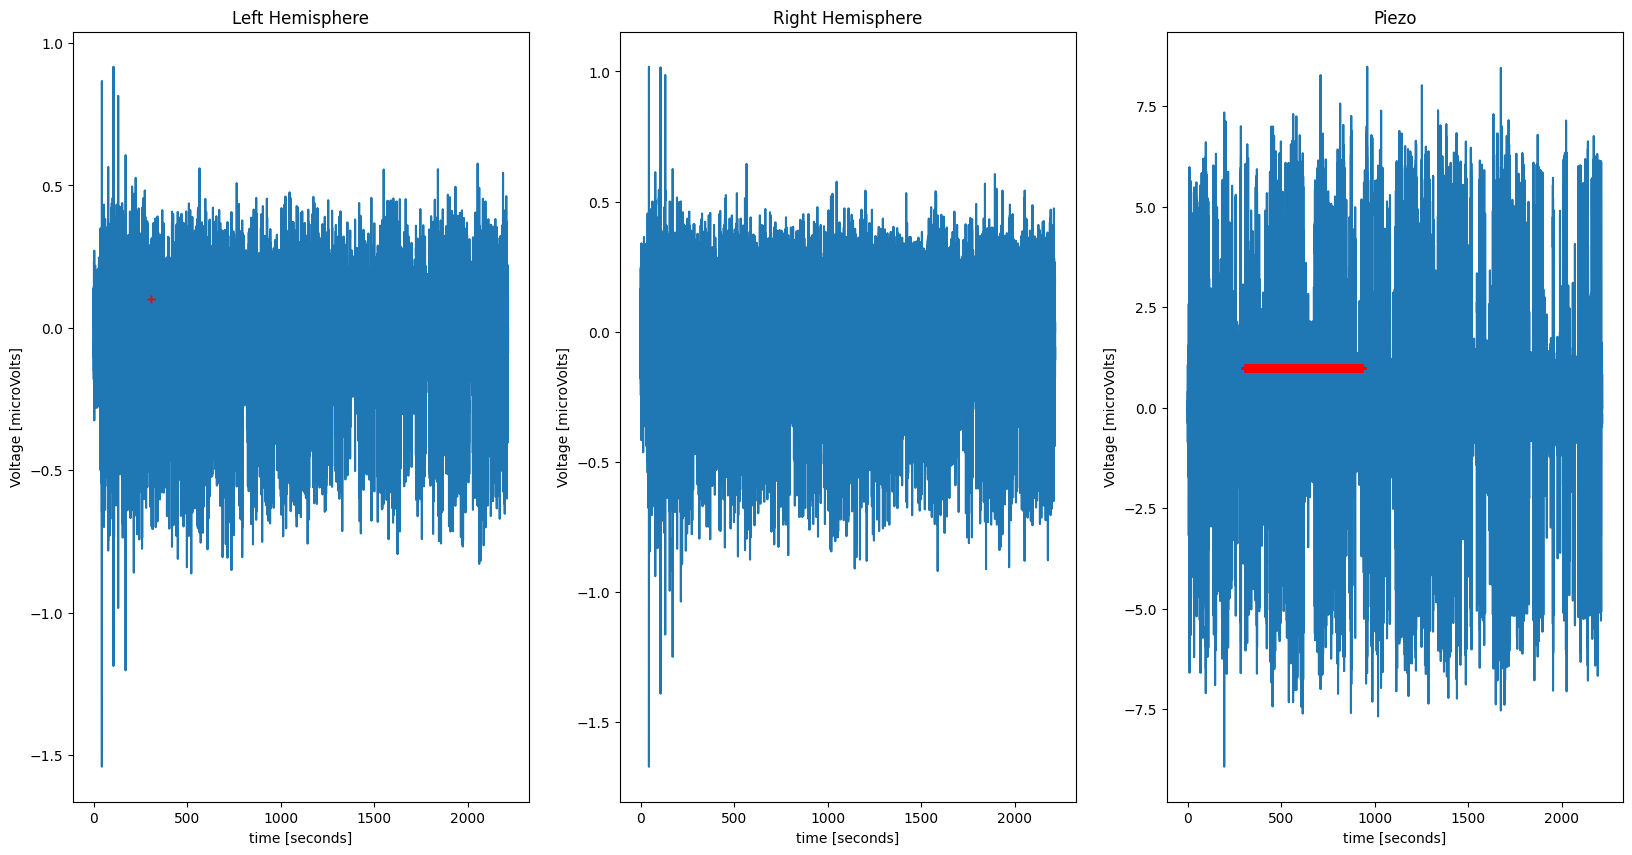

In [1049]:
#Raw Subplots of all 3 channels (Left, Right, Piezo)

f, ax = plt.subplots(1,3, figsize=(20,10))

ax = plt.subplot(1,3,1)
plt.plot(t_axisLH[slc], datLH[slc])
plt.title("Left Hemisphere")
plt.xlabel('time [seconds]')
plt.ylabel('Voltage [microVolts]')
plt.plot(event_times[3],y,'r+')

ax = plt.subplot(1,3,2)
plt.plot(t_axisRH[slc], datRH[slc])
plt.title("Right Hemisphere")
plt.xlabel('time [seconds]')
plt.ylabel('Voltage [microVolts]')
#plt.plot(event_times[2][:],1,'bo')
#plt.plot(event_times[3][:],y,'r+')

ax = plt.subplot(1,3,3)
plt.plot(t_axisPz[slc], datPz[slc])
plt.title("Piezo")
plt.xlabel('time [seconds]')
plt.ylabel('Voltage [microVolts]')
plt.plot(event_times[3][:],y,'r+')